In [22]:
import torch
import torchvision
from torchvision import transforms
from going_modular import data_setup, engine
from torchinfo import summary
from torch import nn
from timeit import default_timer as timer
from helper_functions import plot_loss_curves

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu126
0.21.0+cu126


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from torchinfo import summary
from going_modular import data_setup, engine

In [5]:
from pathlib import Path

data_path = Path("data/")

image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
#manual transform

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, 
                                                                               test_dir,
                                                                               manual_transform, 
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x18a5ea76dd0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
#auto transform

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, 
                                                                               test_dir,
                                                                               auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x18a5ea89dd0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
#creating a pretrained model

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model   = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [13]:
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential: 2-2  

In [14]:
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=len(class_names), 
                    bias=True)).to(device)

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       device=device,
                       epochs=5)

end_time = timer()

print(f"Toatal training time {end_time - start_time:.3f} seconds ")

 20%|██        | 1/5 [00:35<02:20, 35.10s/it]

Epoch: 1 | train_loss: 1.0870 | train_acc: 0.3906 | test_loss: 0.9157 | test_acc: 0.5606


 40%|████      | 2/5 [01:04<01:35, 31.88s/it]

Epoch: 2 | train_loss: 0.8744 | train_acc: 0.7734 | test_loss: 0.7851 | test_acc: 0.8258


 60%|██████    | 3/5 [01:34<01:02, 31.06s/it]

Epoch: 3 | train_loss: 0.7739 | train_acc: 0.8008 | test_loss: 0.7373 | test_acc: 0.8561


 80%|████████  | 4/5 [02:05<00:30, 30.88s/it]

Epoch: 4 | train_loss: 0.7218 | train_acc: 0.7422 | test_loss: 0.6416 | test_acc: 0.8864


100%|██████████| 5/5 [02:36<00:00, 31.33s/it]

Epoch: 5 | train_loss: 0.6214 | train_acc: 0.7930 | test_loss: 0.6350 | test_acc: 0.8352
Toatal training time 156.703 seconds 


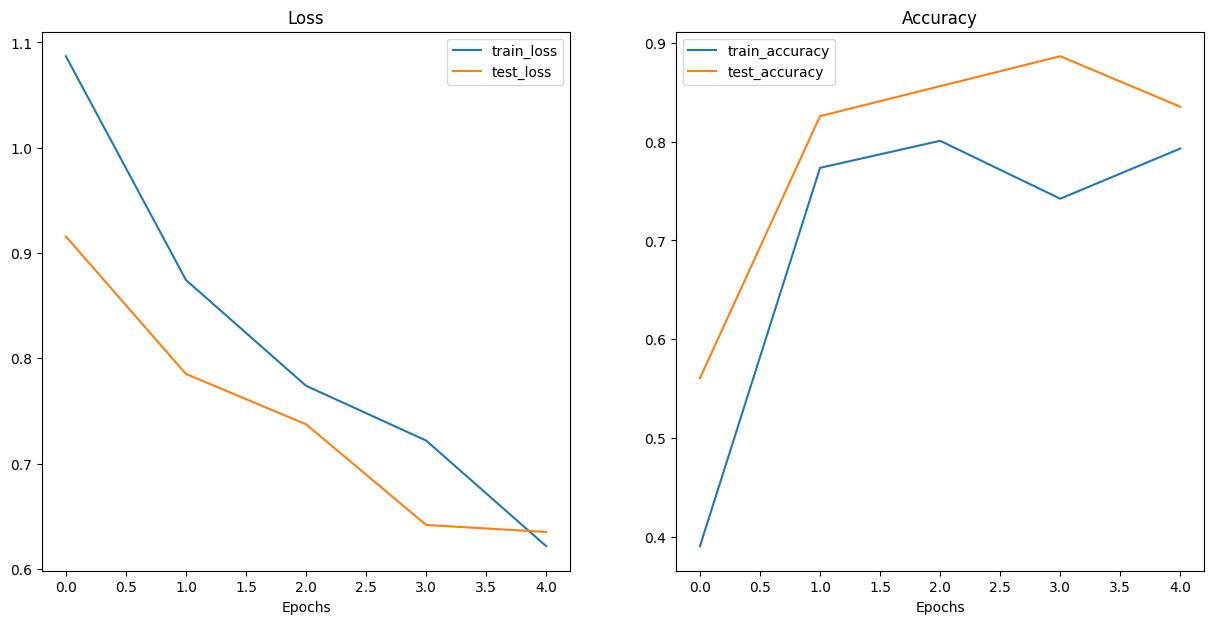

In [23]:
plot_loss_curves(results)